In [1]:
import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv("train_E6oV3lV.csv")
data.drop('id', axis = 1, inplace = True)
data.dropna(inplace = True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
data['tweet'] = data['tweet'].map(str.lower)

In [4]:
class TextPreprocess:
    
    def __init__(self, df, text_column, remove_stopwords=True, remove_punc=True):
        self.df = df
        self.text_column = text_column
        self.remove_stopwords = remove_stopwords
        self.remove_punc = remove_punc
    
    def clean_text(self):
        self.df[self.text_column] = self.df[self.text_column].str.lower()
        
        
        # List of stopwords taken from https://gist.github.com/sebleier/554280
        stopwords = ["a", "about", "above", "after", "again", "against",
                     "all", "am", "an", "and", "any", "are",
                     "as", "at", "be", "because",
                     "been", "before", "being", "below",
                     "between", "both", "but", "by", "could",
                     "did", "do", "does", "doing", "down", "during",
                     "each", "few", "for", "from", "further",
                     "had", "has", "have", "having", "he",
                     "he'd", "he'll", "he's", "her", "here",
                     "here's", "hers", "herself", "him",
                     "himself", "his", "how", "how's", "i",
                     "i'd", "i'll", "i'm", "i've",
                     "if", "in", "into",
                     "is", "isz", "it", "it's", "its",
                     "itself", "let's", "me", "more",
                     "most", "my", "myself", "nor", "of",
                     "on", "once", "only", "or",
                     "other", "ought", "our", "ours",
                     "ourselves", "out", "over", "own", "same",
                     "she", "she'd", "she'll", "she's", "should",
                     "so", "some", "such", "than", "that",
                     "that's", "the", "their", "theirs", "them",
                     "themselves", "then", "there", "there's",
                     "these", "they", "they'd", "they'll",
                     "they're", "they've", "this", "those",
                     "through", "to", "too", "u", "under", "until", "up",
                     "very", "was", "we", "we'd", "we'll",
                     "we're", "we've", "were", "what",
                     "what's", "when", "when's",
                     "where", "where's",
                     "which", "while", "who", "who's",
                     "whom", "why", "why's", "with",
                     "would", "you", "you'd", "you'll",
                     "you're", "you've",
                     "your", "ur", "yours", "yourself", "yourselves"]
        
        if self.remove_stopwords == True:
            self.df[self.text_column] = self.df[self.text_column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
            self.df[self.text_column] = self.df[self.text_column].apply(lambda cw: re.sub(r'<.*?>', '', cw))
        
        def remove_punctuation(text):
            clean_text = re.sub(r'[^\w\s]', '', text)
            return clean_text
        if self.remove_punc == True:
            self.df[self.text_column] = self.df[self.text_column].apply(remove_punctuation)
            
        return self.df

In [5]:
text_processor = TextPreprocess(data, 'tweet', remove_stopwords = True, remove_punc = True)
cleaned_text = text_processor.clean_text()
cleaned_text

,label,tweet
0,0,user father dysfunctional selfish drags kids d...
1,0,user user thanks lyft credit cant use cause do...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society now motivation
...,...,...
31957,0,ate user youuuðððððððððâï
31958,0,see nina turner airwaves trying wrap mantle ge...
31959,0,listening sad songs monday morning otw work sad
31960,1,user sikh temple vandalised calgary wso condem...


In [6]:
# Initialize NLTK resources (download WordNet if not already downloaded)
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

def word_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    words = [x for x in tokens if x.isalpha()]
    return words

# Update the 'tweet' column with tokenized tweets
data['tweet'] = data['tweet'].apply(word_tokenizer)

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    # Map POS tag to first character used by WordNetLemmatizer
    tag = treebank_tag[0]
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if no match

def lemmatize_tweet(tweet_tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag))
                         for word, pos_tag in nltk.pos_tag(tweet_tokens)]
    return lemmatized_tokens

# Apply the lemmatize_tweet function to the 'tweet' column
data['lemmatized_tweet'] = data['tweet'].apply(lemmatize_tweet)
data

,label,tweet,lemmatized_tweet
0,0,"[user, father, dysfunctional, selfish, drags, ...","[user, father, dysfunctional, selfish, drag, k..."
1,0,"[user, user, thanks, lyft, credit, cant, use, ...","[user, user, thanks, lyft, credit, cant, use, ..."
2,0,"[bihday, majesty]","[bihday, majesty]"
3,0,"[model, love, take, time, urð, ðððð, ððð]","[model, love, take, time, urð, ðððð, ððð]"
4,0,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"
...,...,...,...
31957,0,"[ate, user, youuuðððððððððâï]","[eat, user, youuuðððððððððâï]"
31958,0,"[see, nina, turner, airwaves, trying, wrap, ma...","[see, nina, turner, airwave, try, wrap, mantle..."
31959,0,"[listening, sad, songs, monday, morning, otw, ...","[listen, sad, song, monday, morning, otw, work..."
31960,1,"[user, sikh, temple, vandalised, calgary, wso,...","[user, sikh, temple, vandalise, calgary, wso, ..."


In [7]:
def load_glove_embeddings(glove_path):
    glove_embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings
#Loading GloVe model
glove_path = 'glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [9]:
vectorised_tweets = []

for tweet_tokens in data['lemmatized_tweet']:
    vectorised_tokens = [glove_embeddings.get(word, None) for word in tweet_tokens]
    vectorised_tokens = [vec if vec is not None else np.zeros(50) for vec in vectorised_tokens]
    vectorised_tweets.append(np.array(vectorised_tokens))

data['vectorised_words'] = vectorised_tweets

In [11]:
X = data['vectorised_words']
Y = data['label']

# Splitting the data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data['vectorised_words'], data['label'], test_size=0.3, random_state=42)

# Splitting the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

max_seq_length = max(max(map(len, X_train)), max(map(len, X_val)), max(map(len, X_test)))

(array([4.820e+02, 2.471e+03, 5.396e+03, 4.411e+03, 4.819e+03, 3.830e+03,
        7.530e+02, 1.900e+02, 1.800e+01, 3.000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

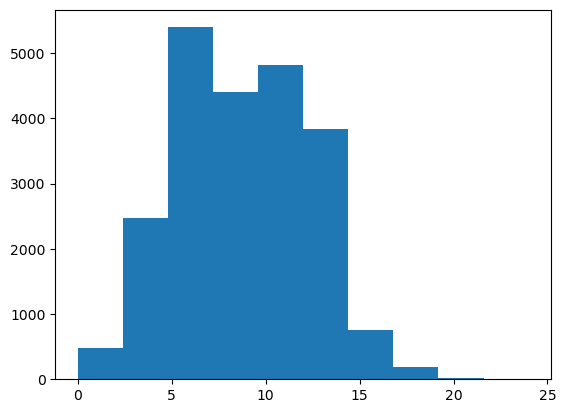

In [12]:
sequence_lengths = []
for i in X_train:
    sequence_lengths.append(len(i))
plt.hist(sequence_lengths)

In [13]:
pd.Series(sequence_lengths).describe()

count    22373.000000
mean         8.710186
std          3.422476
min          0.000000
25%          6.000000
50%          9.000000
75%         11.000000
max         24.000000
dtype: float64

In [14]:
# Define the pad_X function
def pad_X(X, desired_sequence_length = max_seq_length):
    padded_X = pad_sequences(X, maxlen = desired_sequence_length, dtype='float32', padding='post', truncating='post')
    return padded_X

# Apply padding to the sequences
X_train_padded = pad_X(X_train)
X_val_padded = pad_X(X_val)
X_test_padded = pad_X(X_test)

In [21]:
X_train_padded.shape, X_test_padded.shape, X_val_padded.shape, y_train.shape, y_test.shape, y_val.shape

((22373, 26, 50), (4795, 26, 50), (4794, 26, 50), (22373,), (4795,), (4794,))

In [23]:
# Build the neural network model
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(max_seq_length, 50)))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))

model.add(GlobalMaxPooling1D())  # Better suited for sequence tasks
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=10, batch_size=64, verbose=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 26, 128)           91648     
                                                                 
 dropout_4 (Dropout)         (None, 26, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 26, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 26, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 26, 32)            12416     
                                                                 
 dropout_6 (Dropout)         (None, 26, 32)            0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 32)               

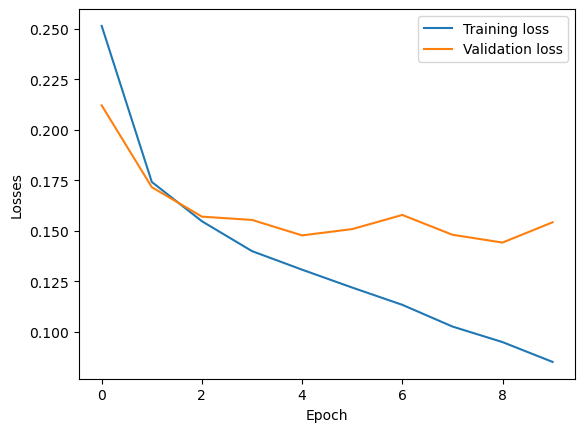

In [29]:
# Plot the accuracy graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.show()

The sweet spot in terms of number of epochs is 4 or 5